# Construcción de un portfolio *equally weighted*

Un portfolio *equally weighted* consiste en invertir el mismo porcentaje del dinero asignado en cada uno de los activos del portfolio, esto es, $w_i = 1/n$, donde $n$ corresponde a la cantidad de activos en el portfolio. Para este ejemplo, construiremos un portfolio con 5 acciones: *TSLA*, *IBM*, *AAPL*, *NVDA*, *INTC*.

In [9]:
#!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

activos = ["TSLA"] #, "IBM", "AAPL", "NVDA", "INTC"]
n = len(activos)

precios = yf.download(activos, start = "2023-01-01", end = "2023-11-10", auto_adjust=True)
precios.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,


In [10]:
yf.download("AAPL", start = "2023-01-01", end = "2023-11-10", auto_adjust=True).head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


In [11]:
retornos = precios["Close"].pct_change().dropna()
retornos.head()

Ticker,TSLA
Date,


Luego, deberemos definir una lista donde cada componente sea igual a $1/n = 1/5 = 0.2$. Para ello usamos la siguiente sintaxis: `n * [1/n]`

In [12]:
pesos = n * [1/n]
pesos

[1.0]

Ahora, lo que deberemos hacer es multiplicar la matriz de retornos por el vector de pesos para obtener la rentabilidad del portfolio, esto es: 

$$r_{p,t} = \sum_{i=1}^n w_{i,t} \times r_{i,t} = W_t (r_t)'$$

Entonces, deberemos invertir la matriz de retornos usando el método `T`, y haciendo la sumaproducto. Esto último se hace con el método `dot` de Numpy. Finalmente, convertiremos el resultado en formato pandas para poder seguir trabajando con los resultados.


In [13]:
rp = pd.Series(np.dot(pesos, retornos.T), index=retornos.index)
rp.head()

Series([], dtype: float64)

Una librería útil para poder estudiar la rentabilidad de un portfolio es `quantstats`. Esta permite graficar el rendimiento de un activo o portfolio, pero también nos permite obtener métricas de rendimiento.

In [14]:
#!pip install quantstats

import quantstats as qs

qs.plots.snapshot(rp, title = "Rendimiento del portfolio equally-weighted")

IndexError: index 0 is out of bounds for axis 0 with size 0

Para obtener métricas se debe utilizar el método `reports.metrics`. En él se debe especificar:
* benchmark: El benchmark a utilizar. Puede ser una Serie de Pandas o un ticker (lo descarga desde Yahoo! Finance, por lo que se debe llamar a la librería `yfinance`)
* rf: Retorno del activo libre de riesgo. En este caso usaré los bonos a 10 años plazo.
* mode: puede ser "basic" o "full".


In [ ]:
rf = .04628
qs.reports.metrics(rp, benchmark = "SPY", rf = rf, mode = "full", prepare_returns = False)

[*********************100%%**********************]  1 of 1 completed
                           Benchmark (SPY)    Strategy
-------------------------  -----------------  ----------
Start Period               2023-01-04         2023-01-04
End Period                 2023-11-09         2023-11-09
Risk-Free Rate             4.63%              4.63%
Time in Market             100.0%             100.0%

Cumulative Return          13.05%             73.36%
CAGR﹪                     10.52%             56.63%

Sharpe                     0.79               2.57
Prob. Sharpe Ratio         64.07%             97.11%
Smart Sharpe               0.71               2.3
Sortino                    1.17               4.32
Smart Sortino              1.04               3.86
Sortino/√2                 0.83               3.06
Smart Sortino/√2           0.74               2.73
Omega                      1.51               1.51

Max Drawdown               -10.29%            -12.37%
Longest DD Days            10

Usando el método `reports.html` se puede crear un reporte en formato html con los gráficos y métricas para analizar al portfolio.

In [ ]:
qs.reports.html(rp, benchmark = "SPY", rf = rf, title = "Rendimiento del portfolio equally-weighted", download_filename = "reporte.html")

# En Google Colab, se debe agregar el parámetro output:
# qs.reports.html(rp, benchmark = "SPY", rf = rf, title = "Rendimiento del portfolio equally-weighted", download_filename = "reporte.html", output = "reporte.html")

[*********************100%%**********************]  1 of 1 completed


C:\Users\gabriel.valenzuela.o\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


# Frontera eficiente

La *Frontera eficiente* corresponde a las mejores combinaciones de **riesgo** y **retorno** de un conjunto de activos. Para conocer esta frontera, se debe resolver el siguiente problema:

$$\min W' \Sigma W $$
$$s.a. E(r_p) = W \times E(r_i)$$

En otras palabras, la frontera eficiente son las mejores combinaciones de riesgo-retorno que podemos encontrar con $n$ activos. Para construirla debemos resolver este problema de optimización dado los distintos retornos esperados que necesitemos. Una forma sencilla de realizarlo es a través del módulo `optimize`de `scipy`.

In [ ]:
import numpy as np
import scipy.optimize as sco

Dadop que este es un proceso iterativo, deberemos construir algunas funciones:

In [ ]:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constr = (
            {"type": "eq", 
             "fun": lambda x: get_portf_rtn(x, avg_rtns) - ret},
            {"type": "eq", 
             "fun": lambda x: np.sum(x) - 1}
        )
        ef_portf = sco.minimize(get_portf_vol, 
                                initial_guess, 
                                args=args, method="SLSQP", 
                                constraints=constr,
                                bounds=bounds)
        efficient_portfolios.append(ef_portf)
    
    return efficient_portfolios

Para este ejemplo asumiremos que el retorno esperado es igual al retorno promedio histórico. Este es un **pésimo supuesto**, dado que estamos considerando que el pasado es igual al futuro. Dado que tenemos datos diarios, lo anualizaremos multiplicándolos por 252 días. A su vez, calcularemos la matriz de covarianza de forma análoga.

In [ ]:
avg_returns = retornos.mean() * 252
cov_mat = retornos.cov() * 252

Definiremos distintos valores objetivo de retorno esperado:

In [ ]:
rtns_range = np.linspace(0.1, 0.55, 200)

Luego, correremos el proceso de optimización:

In [ ]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

Rescataremos las varianzas del portfolio desde el proceso de optimización:

In [ ]:
vols_range = [x["fun"] for x in efficient_portfolios]

Finalmente, graficamos:

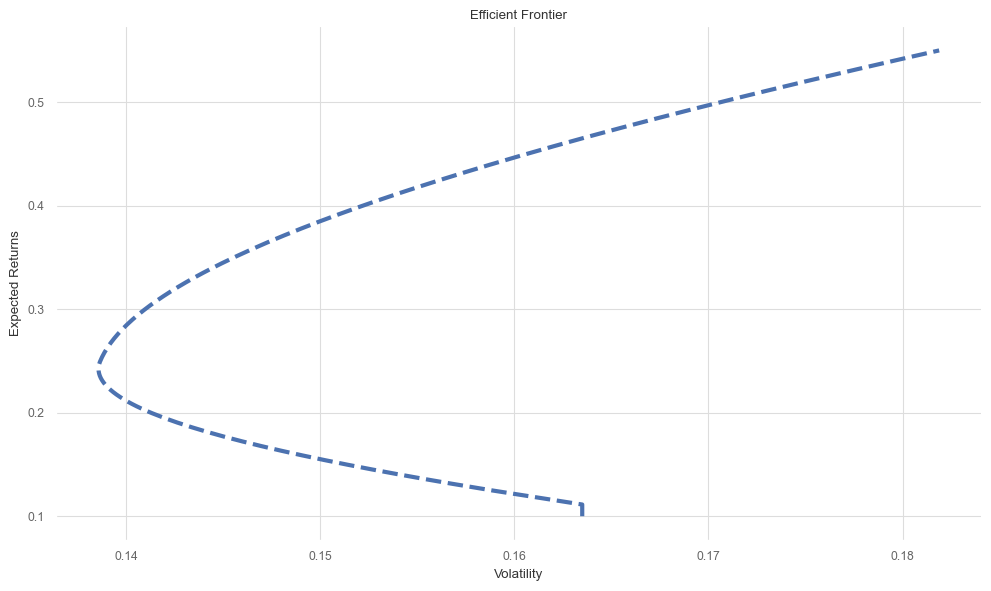

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    ax.plot(vols_range, rtns_range, "b--", linewidth=3)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")

    sns.despine()
    plt.tight_layout()

¿Por qué la frontera eficiente tiene esta forma? Calculemos portfolios aleatorios para incorporarlos al gráfico:

In [ ]:
np.random.seed(123)
weights = np.random.random(size=(10**5, n))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

Y en base a ellos, calculemos retorno esperado, varianza, y ratio de Sharpe:

In [ ]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    )
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = (portf_rtns - rf*12) / portf_vol

portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)

portf_results_df

,returns,volatility,sharpe_ratio
0,0.797747,0.282155,0.859056
1,0.590905,0.212304,0.167424
2,0.469778,0.204568,-0.418354
3,0.813428,0.277736,0.929185
4,0.665951,0.237896,0.464872
...,...,...,...
99995,0.742851,0.259194,0.723363
99996,0.682046,0.237523,0.533362
99997,0.745423,0.256429,0.741194
99998,0.854497,0.298690,1.001496


Ahora grafiquemos:

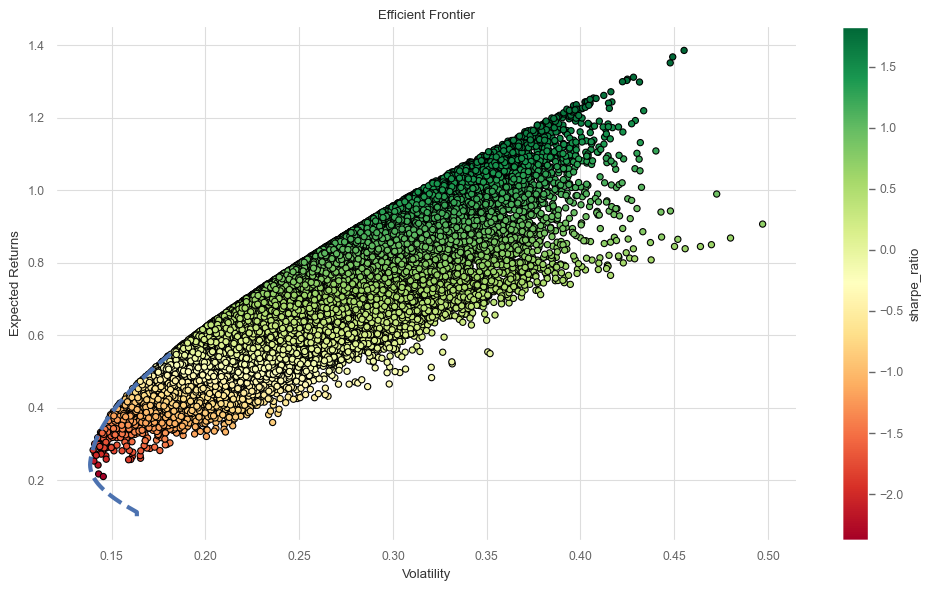

In [ ]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.plot(vols_range, rtns_range, "b--", linewidth=3)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")

    sns.despine()
    plt.tight_layout()

Como se puede apreciar, todos los portfolios caen **por debajo de** la frontera eficiente.

Por otro lado, ¿cuál es el portfolio de mínima varianza?

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]["fun"]

min_vol_portf = {
    "Return": min_vol_portf_rtn,
    "Volatility": min_vol_portf_vol,
    "Sharpe Ratio": ((min_vol_portf_rtn - rf) / min_vol_portf_vol)
}

min_vol_portf

{'Return': 0.24246231155778897,
 'Volatility': 0.13858564949692428,
 'Sharpe Ratio': 1.4156033634791527}

# Optimizando portfolios con Riskfolio-Lib

Una librería bastante popular para realizar optimizaciones de portfolio es `Riskfolio-lib`. Además de realizar una típica optimización por media-varianza, también permite utilizar otras métricas de riesgo, como CVar.

In [ ]:
!pip install pybind11
!pip install cvxpy


In [ ]:
!pip install riskfolio-lib

In [ ]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=retornos)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.397298,0.09645,0.082714,0.39981,0.023728


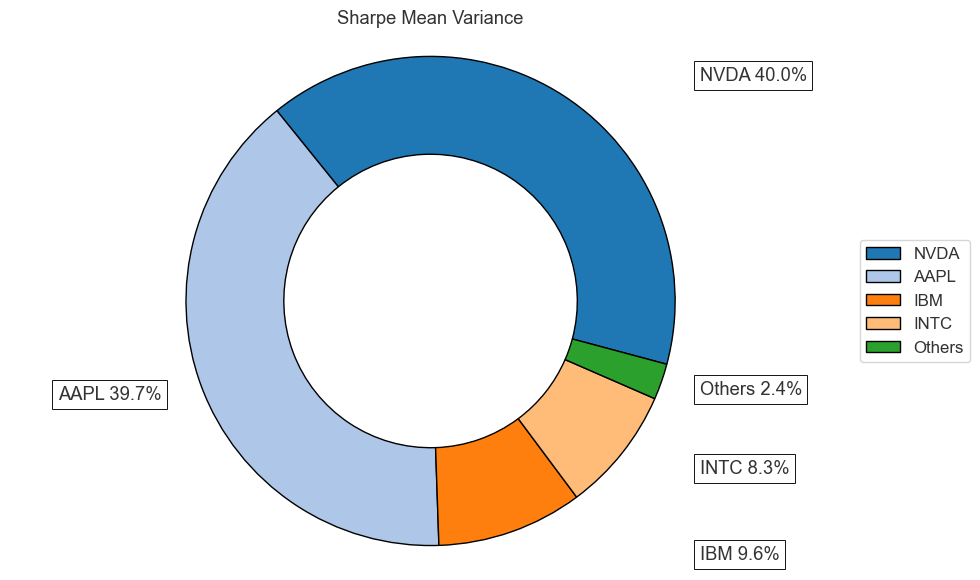

In [ ]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [ ]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,IBM,INTC,NVDA,TSLA
0,0.348321,0.635853,0.015826,1.171091e-08,6.986815e-09
1,0.373438,0.526330,0.030603,6.962889e-02,4.365887e-07
2,0.377896,0.480029,0.036386,1.056880e-01,2.784995e-07
3,0.381460,0.443034,0.041018,1.344869e-01,1.022920e-06
4,0.384574,0.410708,0.045065,1.596535e-01,2.457099e-07


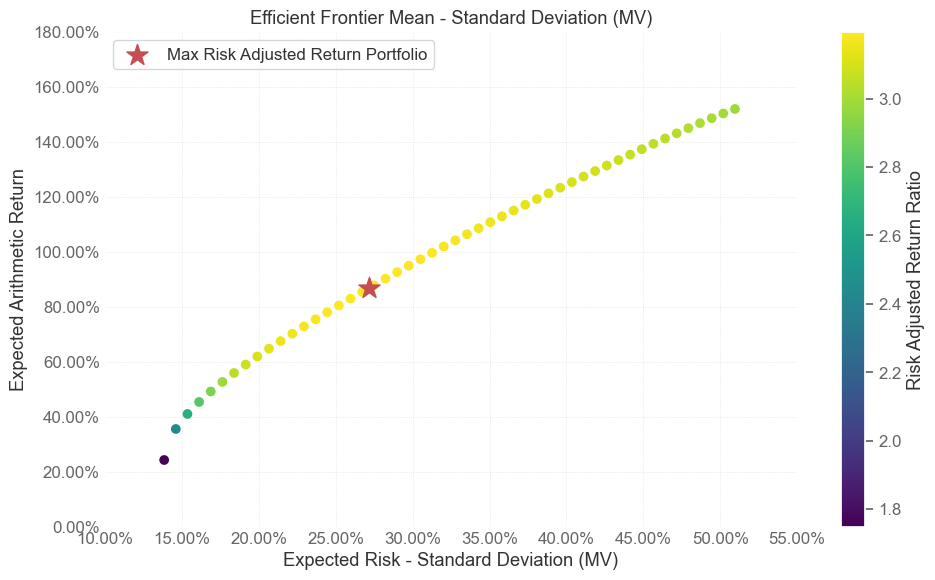

In [ ]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

## CVar

In [ ]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.355542,0.106248,0.016991,0.521219,3.380408e-11


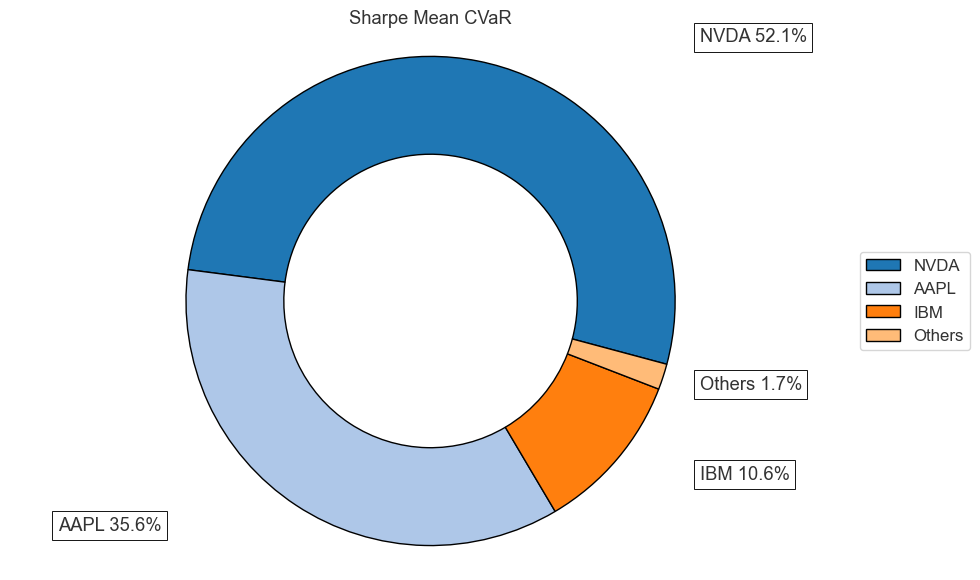

In [ ]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [ ]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,IBM,INTC,NVDA,TSLA
0,0.401620,0.480945,0.066391,0.051045,2.489810e-11
1,0.304913,0.504182,0.023761,0.167145,6.804677e-13
2,0.337273,0.413997,0.054082,0.194647,1.336453e-12
3,0.347127,0.380319,0.048627,0.223927,4.807666e-12
4,0.359682,0.362945,0.019152,0.258220,9.525211e-12


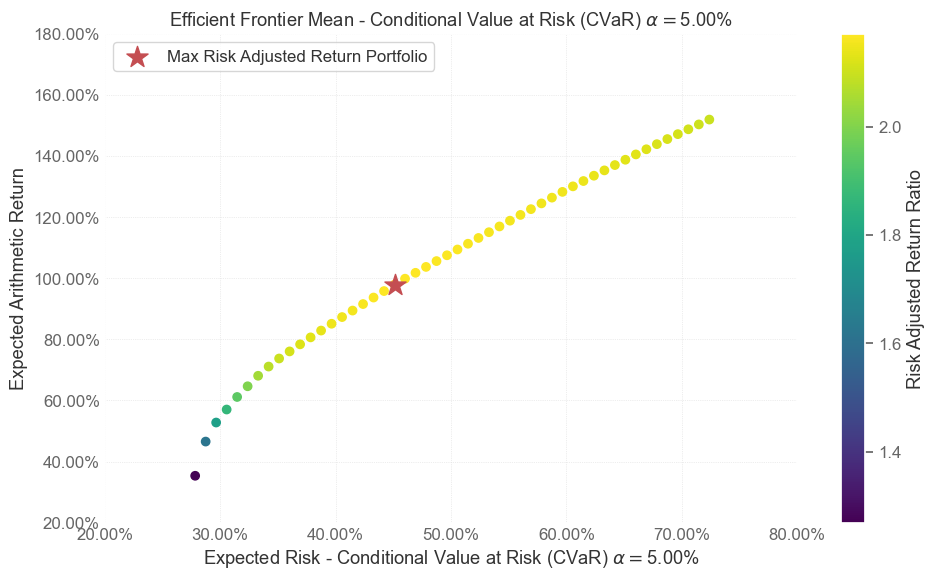

In [ ]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
AAPL,39.73%,16.87%,17.61%,14.21%,18.08%,35.55%,16.22%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IBM,9.64%,4.21%,14.81%,23.44%,14.17%,10.62%,22.21%,28.43%,0.00%,0.00%,0.00%,0.00%,0.00%
INTC,8.27%,0.00%,2.75%,0.00%,3.87%,1.70%,5.12%,12.05%,0.00%,26.83%,26.83%,26.83%,26.83%
NVDA,39.98%,77.41%,64.83%,62.35%,63.88%,52.12%,56.46%,59.52%,100.00%,73.17%,73.17%,73.17%,73.17%
TSLA,2.37%,1.51%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


# Calculando modelo CAPM

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

RISKY_ASSET = "AMZN"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2022-12-31"

In [ ]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 auto_adjust=True)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
X = (
    df["Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("M")
    .last()
    .pct_change()
    .dropna()
)
X

C:\Users\gaval\AppData\Local\Temp\ipykernel_164\2109034759.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


Ticker,asset,market
Date,,
2016-02-29,-0.058739,-0.004128
2016-03-31,0.074423,0.065991
2016-04-30,0.111094,0.002699
2016-05-31,0.095817,0.015325
2016-06-30,-0.009920,0.000911
...,...,...
2022-08-31,-0.060615,-0.042440
2022-09-30,-0.108622,-0.093396
2022-10-31,-0.093451,0.079863


In [ ]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.2162520663612193

In [ ]:
import statsmodels.formula.api as smf

X = df["Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("M") \
                   .last() \
                   .pct_change() \
                   .dropna()

# define and fit the regression model 
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     54.97
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.06e-10
Time:                        21:09:21   Log-Likelihood:                 104.55
No. Observations:                  83   AIC:                            -205.1
Df Residuals:                      81   BIC:                            -200.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0053      0.008      0.678      0.5

## Fama - French

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [ ]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2022-12-31"

In [ ]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

In [ ]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202311 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (84 rows x 4 cols)
  1 : Annual Factors: January-December (7 rows x 4 cols)


In [ ]:
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001
2016-02,-0.0007,0.0073,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001


In [ ]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
y = asset_df["Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y.head()

Date
2016-02   -0.001287
2016-03    0.127210
2016-04   -0.139921
2016-05    0.071773
2016-06   -0.042660
Freq: M, Name: rtn, dtype: float64

In [ ]:
factor_3_df = factor_3_df.join(y)
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)
factor_3_df.head()

,MKT,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,0.127210,0.127010
2016-04,0.0091,0.0076,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.071773,0.071673


In [ ]:

# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ MKT + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     31.56
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.63e-13
Time:                        21:09:24   Log-Likelihood:                 118.56
No. Observations:                  83   AIC:                            -229.1
Df Residuals:                      79   BIC:                            -219.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0116      0.007      1.734      0.0

## Modelo de 4 factores

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

# three factors 
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

# momentum factor
momentum_df = web.DataReader("F-F_Momentum_Factor", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

In [ ]:
# join all datasets on the index
factor_4_df = factor_3_df.join(momentum_df).join(y)

# rename columns
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]

# divide everything (except returns) by 100
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100

# calculate excess returns
factor_4_df["excess_rtn"] = (
    factor_4_df["rtn"] - factor_4_df["rf"]
)

factor_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,0.0144,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.0438,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.127210,0.127010
2016-04,0.0091,0.0076,0.0328,0.0001,-0.0602,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.0142,0.071773,0.071673


In [ ]:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom", 
    data=factor_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     24.58
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           3.49e-13
Time:                        21:09:25   Log-Likelihood:                 119.71
No. Observations:                  83   AIC:                            -229.4
Df Residuals:                      78   BIC:                            -217.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0103      0.007      1.548      0.1